## Exercice de Machine learning

# Stroke Prediction Dataset (Prédiction des AVC)

Le jeu de données que j'exploite pour ce projet est *Stroke Prediction Dataset*, disponible sur Kaggle à l'URL suivante : https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset. La personne qui a partagé ce jeu de données en opensource a indiqué la source d'origine comme confidentielle.

Celui-ci est utilisé pour prédire si oui ou non un patient est susceptible de développer un AVC (accident vasculaire cérébral). Il est constitué de **5 110 observations** et **10 variables explicatives** pour **1 variable à expliquer** (ainsi qu'une clé `id`, qui donne un identifiant unique à chaque individu), que je décris brievement ci-dessous telles qu'elles sont dans le jeu de données initial, avant leur prétraitement :

* `gender` (qualitative) : genre de l'individu (`Male` = homme, `Female` = femme ou `Other` = autre)

* `age` (qualitative) : âge de l'individu

* `hypertension` (binaire) : `1` si l'individu fait de l'hypertension, `0` sinon

* `heart_disease` (binaire) : `1` si l'individu a des problèmes cardiaques, `0` sinon

* `ever_married` (binaire) : `yes` si l'individu a déjà été marié, `no` sinon

* `work_type` (qualitative) : secteur de travail de l'individu (`children` = enfant, `Govt_jov` = public, `Private` = privé, `Self-employed` = indépendant ou `Never_worked` = n'a jamais travaillé)

* `Residence_type` (binaire) : milieu d'habitation de l'individu (`Rural` ou `Urban`)

* `avg_glucose_level` (quantitative) : niveau moyen de glucose dans le sang de l'individu (en mg/dL de sang)

* `bmi` (quantitative) : IMC de l'individu (en kg/m²)

* `smoking_status` : statut de fumeur de l'individu (`formerly smoked` = a déjà fumé par le passé, `never smoked` = n'a jamais fumé, `smokes` = fume ou `Unknown` = n/a)

* `stroke` (binaire, **variable à expliquer**) : `1` si l'individu a fait un AVC, `0` sinon

In [2]:
# import des packages et des données
!pip install fanalysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from fanalysis.ca import CA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.1 MB/s eta 0:00:00


In [3]:
from google.colab import files
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [4]:
# import des données
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
print(df)

         id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  former

Je visualise le cardinal pour chaque catégorie de chaque variable qualitative.

In [5]:
categories = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for category in categories:
    print(f"Cardinal pour {category}:")
    print(df[category].value_counts())
    print()

Cardinal pour gender:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Cardinal pour ever_married:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64

Cardinal pour work_type:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

Cardinal pour Residence_type:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

Cardinal pour smoking_status:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64



On remarque que la catégorie `Other` de la variable `gender` n'a qu'une seule occurrence dans tout le jeu de données. Cela étant dérisoire par rapport au nombre total d'observations, je décide de retrancher la ligne de l'individu associé de sorte à faire de `gender` une variable binaire.

In [6]:
df = df[df["gender"]!="Other"]

### Prétraitement des données

Dans un premier temps, je prends connaissance des variables qui comprennent des valeurs manquantes.

In [7]:
na = df.isnull().sum()
print(na[na>0])

bmi    201
dtype: int64


La variable `bmi` (indicateur d'IMC) est la seule qui contient des valeurs manquantes, en l'occurrence 201.

Pour le prétraitement des données, je retire la variable `id` qui n'apporte pas d'information nouvelle aux données (clé unique pour chaque observation), je remplace les valeurs manquantes de `bmi` par la moyenne des valeurs non-manquantes puis j'arrondis les valeurs de cette variable à une décimale. Je rempalce également les valeurs de la variable binaire `ever_married` par `0` pour "non" et `1` pour "oui", et j'arrondis les nombres flottants de `age` à l'entier le plus proche. Pour finir, je fais les deux hypothèses que :
* les enfants d'âge inférieur ou égal à 15 ne travaillent pas (valeur `children` pour la variable `work_type`) ;
* les enfants d'âge inférieur ou égal à 10 n'ont jamais fumé (valeur `never smoked` pour la variable `smoking_status`)

Cela a pour objectif de s'affranchir des valeurs manquantes et corriger les quelques valeurs incohérentes de la base.

In [8]:
# retrait de la colonne identifiant
df.drop(columns=["id"], inplace=True)

# remplacement des n/a de la variable de l'IMC par la moyenne, et arrondi à 1 chiffre après la virgule
mean_bmi = df["bmi"].mean()
df["bmi"].fillna(mean_bmi,inplace=True)
df["bmi"] =df["bmi"].round(1)

# remplacement des "Yes" et "No" de la variable ever_married par respectivement 1 et 0
df["ever_married"] = df["ever_married"].replace({"No":0, "Yes":1})

# arrondi des nombres flottants de la colonne age à l'entier le plus proche
df["age"] = df["age"].round()
df["age"] = df["age"].astype(int)

# fixer la variable work_type à "children" pour les age <= 15 et smoking_status à "never smoked" pour les age <= 10
df.loc[df["age"]<=15, "work_type"] ="children"
df.loc[df["age"]<=10, "smoking_status"] = "never smoked"

print(df.head())

   gender  age  hypertension  heart_disease  ever_married      work_type  \
0    Male   67             0              1             1        Private   
1  Female   61             0              0             1  Self-employed   
2    Male   80             0              1             1        Private   
3  Female   49             0              0             1        Private   
4  Female   79             1              0             1  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21  28.9     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1  


<ipython-input-8-7c083be90c8a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["id"], inplace=True)
<ipython-input-8-7c083be90c8a>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bmi"].fillna(mean_bmi,inplace=True)
<ipython-input-8-7c083be90c8a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

### Statistiques descriptives

**Je consacre cette première partie à l'analyse descriptive des données.** Dans un premier temps, je visualise la répartition des données par catégorie pour les 8 variables qualitatives, par le biais de diagrammes circulaires.

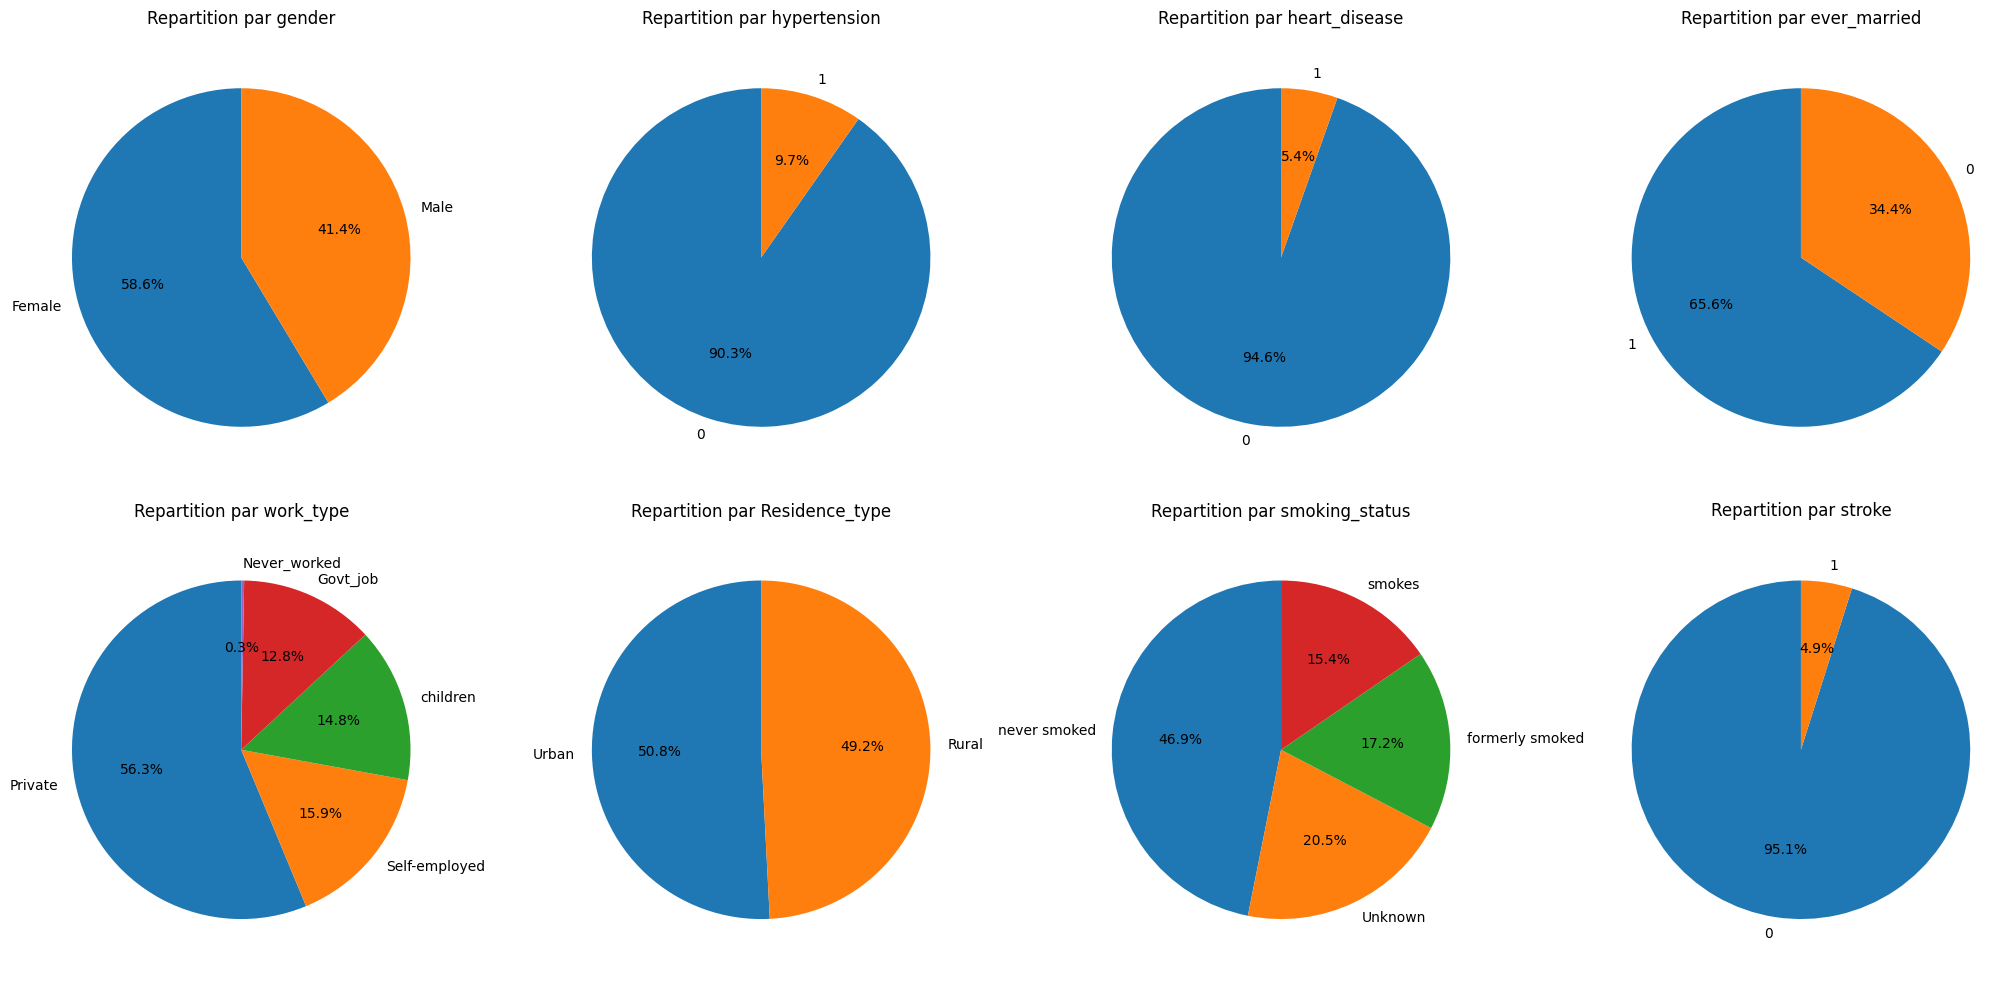

In [9]:
fig, axs = plt.subplots(2,4,figsize=(20,10))
axs= axs.flatten()

quali = ["gender","hypertension","heart_disease","ever_married","work_type","Residence_type","smoking_status","stroke"]

for i,var in enumerate(quali):
    counts = df[var].value_counts()
    axs[i].pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90)
    axs[i].axis("equal")
    axs[i].set_title(f'Repartition par {var}')

plt.tight_layout()
plt.show()

Dans ce jeu de données majoritairement féminin, 9,7 % des individus font de l'hypertension et 5,4 % ont des problèmes cardiaques. À peu près 1/3 des individus ont déjà été mariés, et la répartition entre individus vivant en milieu rural et en milieu urbain est équivalente. Enfin, dans cet échantillon, 4,9 % des individus ont déjà fait un AVC, qui est la variable que l'on cherche à expliquer. Près de la moitié de l'échantillon n'a jamais fumé, et 15,4 % fume. Un quart des individus sont des enfants, et plus de la moitié travaillent dans le secteur privé.

On peut ensuite regarder la matrice des corrélations (et la carte thermique associée en arrière-plan).

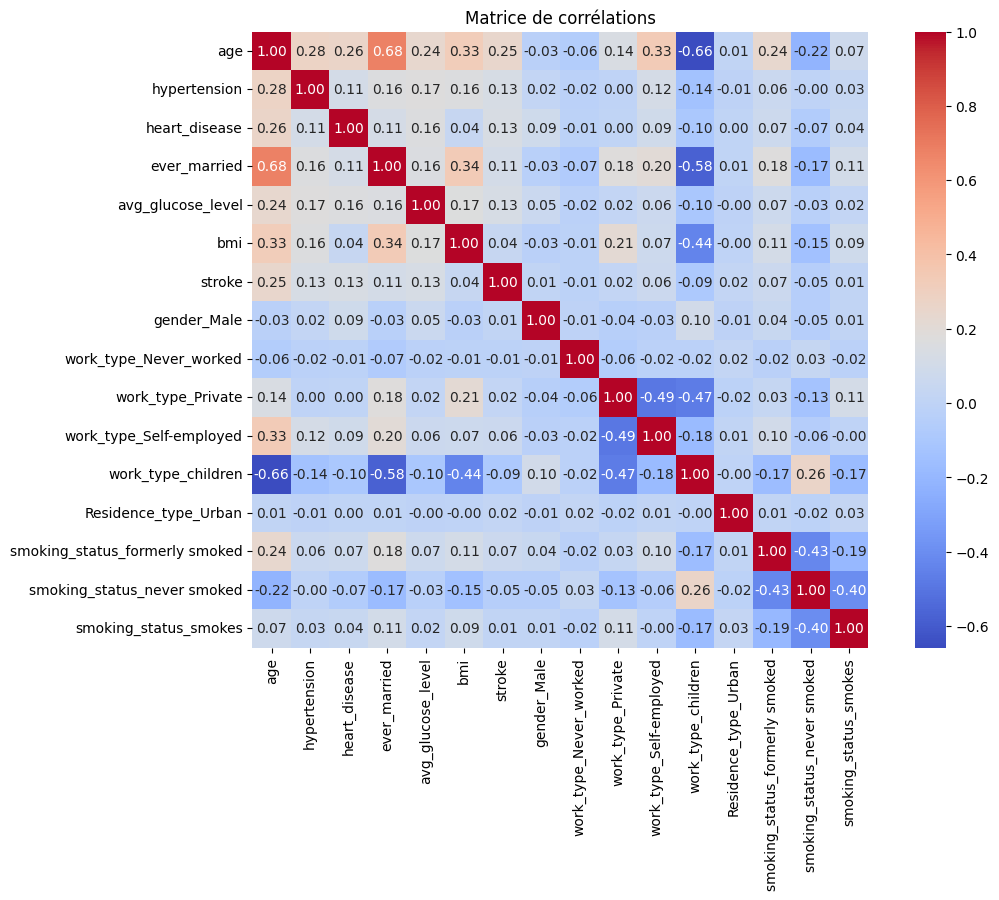

In [10]:
# on encode les catégories des variables qualitatives qui ne le sont pas déjà (one-hot encoding)
df = pd.get_dummies(df,columns=["gender","work_type","Residence_type","smoking_status"],drop_first=True)

matrice = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(matrice,annot=True, fmt=".2f",cmap="coolwarm", square=True, cbar=True)
plt.title('Matrice de corrélations')
plt.show()

### Standardisation des variables quantitatives

Je procède à une standardisation/normalisation des variables quantitatives (`age`, `avg_glucose_level` et `bmi`) de sorte à les mettre à la même échelle. Cela consiste à les centrer en leur retranchant leur moyenne $\mu^i$ puis les réduire en divisant les données centrées par leur écart-type $\sigma^i$, pour $i \in \{ \text{age}, \text{avg_glucose_level}, \text{bmi} \}$ : $$X_\text{norm}^i = \frac{X^i - \mu^i}{\sigma^i}$$

In [11]:
quanti = ["age","avg_glucose_level","bmi"]

scaler = StandardScaler()
df[quanti] = scaler.fit_transform(df[quanti])

print(df.head())

        age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0  1.051238             0              1             1           2.706450   
1  0.785886             0              0             1           2.121652   
2  1.626168             0              1             1          -0.004867   
3  0.255181             0              0             1           1.437473   
4  1.581943             1              0             1           1.501297   

        bmi  stroke  gender_Male  work_type_Never_worked  work_type_Private  \
0  1.001006       1         True                   False               True   
1  0.000679       1        False                   False              False   
2  0.468364       1         True                   False               True   
3  0.715198       1        False                   False               True   
4 -0.635893       1        False                   False              False   

   work_type_Self-employed  work_type_children  Residence_type

### Machine learning

Au vu du faible nombre de variables quantitatives, une ACP (analyse en composantes principales) n'est pas adaptée : ces données sont déjà en faible dimension dans leur espace initial (on pourrait passer de 3 dimensions à 2 dimensions, mais cela apporterait peu d'information nouvelle). Je procède d'abord à une AFC (analyse factorielle des correspondances) sur les données qualitatives en utilisant le package `fanalysis`.

In [12]:
print(df.columns)

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'stroke', 'gender_Male',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')


In [14]:
# print(afc_data.dtypes)
# print(afc_data.head())

In [15]:
# afc_columns = ["gender_Male", "work_type_Never_worked", "work_type_Private", "work_type_Self-employed", "work_type_children", "Residence_type_Urban", "smoking_status_formerly smoked",
#                "smoking_status_never smoked", "smoking_status_smokes", "stroke"]

# afc_data = df[afc_columns]
# print(afc_data.head())

# ca = CA()
# ca.fit(afc_data)

# Apprentissage supervisé

Comme nous pouvons le voir, le jeu de données est déséquilibré pour ce qui concerne la classe `stroke`, avec moins de 5 % des patients ayant fait un AVC :

In [16]:
print(df["stroke"].value_counts())
print(df["stroke"].value_counts(1))

stroke
0    4860
1     249
Name: count, dtype: int64
stroke
0    0.951262
1    0.048738
Name: proportion, dtype: float64


Cela est problématique car, dans ce cas de figure de jeux de données déséquilibrés, les algorithmes de ML ont tendance a mieux apprendre à prédire la classe majoritaire au détriment de la classe minoritaire. Dans notre cas de figure, cela est susceptible de provoquer une inefficacité de l'algo pour prédire quels patients seraient susceptibles de contracter un AVC, ce qui pose problème étant donné qu'il s'agit de notre **variable cible**, et plus précisément de l'objectif de nos modèles. Pour pallier ce problème, on peut appliquer ce qu'on appelle une **méthode de suréchantillonnage** (ou, inversement, une méthode de sous-échantillonnage), qui consiste à augmenter artificiellement la proportion des observations pour lesquelles la classe de la variable cible est minoritaire (`stroke` à `1` dans notre cas) de sorte à "combler le vide" de la différence des fréquences entre classes. Cependant, avec une duplication simple, cela peut provoquer du **surapprentissage** car l'algo risque d'apprendre trop spécifiquement les données artificielles ; pour pallier ce problème, diverses méthodes ont été créées telles que le SMOTE (*synthetic minority oversampling technique*) ou encore l'ADASYN (*adaptive synthetic sampling*), mais elles sont davantages adaptées aux jeux de données majoritairement quantitatifs car elles reposent sur un prnicipe d'interpolation entre valeurs de variables pour la création des nouvelles "pseudo-observations".

Dans la suite, pour notre régression logistique, notre forêt aléatoire puis notre boosting, on utilise SMOTE-NC (*synthetic minority oversampling technique or nominal and continuous*) qui est une variante de SMOTE adaptée aux données à variables majoritairement qualitatives car, plutôt qu'interpoler les valeurs des variables quantitatives, elles sélectionne simplement une catégorie des variables qualitatives présente dans les observations minoritaires lors de la génération des pseudo-observations.

Pour commencer, on divise le jeu de données normalisé en un ensemble d'entraînement (train) et un ensemble de test, qui comprend 1/4 des observations :

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = df.drop("stroke",axis=1) # matrice X
y = df["stroke"] # vecteur y

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=100)

## Régression logistique

Dans un premier temps, on procède à une régression logistique. Pour ce faire, on utilise les variables binaires (transformées grâce à `dummy`)

#### **Sans suréchantillonnage**

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train, y_train) # entrainement

y_pred = log_reg.predict(X_test)

On peut calculer l'accuracy du modèle, ie sa performance sur les données de test. Cependant, cette métrique est biaisée en présence de données déséquilibrées car elle est fortement influencée par la classe majoritaire de la variable cible : la "non-survenue" d'AVC dans notre cas

In [19]:
print(f"Accuracy : {accuracy_score(y_test,y_pred)}")

Accuracy : 0.9561815336463224


En regardant de plus près le rapport de classification, on se rend compte que le modèle est pitoyable pour prédire les survenues d'AVC...

In [20]:
print("Rapport de classification :","\n",classification_report(y_test,y_pred))

Rapport de classification : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1222
           1       0.00      0.00      0.00        56

    accuracy                           0.96      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.96      0.93      1278



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC : {roc_auc:.4f}")

AUC-ROC : 0.8419


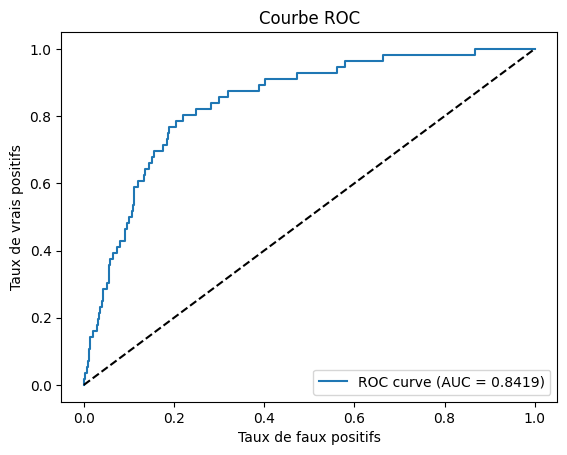

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

#### **Avec suréchantillonnage SMOTE-NC**

On utilise à présent la méthode de suréchantillonnage SMOTE-NC (proposée par la librairie `imbalanced-learn`), qui vise à pallier le problème des données déséquilibrées en présence de variables qualitatives.

In [23]:
from imblearn.over_sampling import SMOTENC

categorical_features = [1,2,3,6,7,8,9,10,11,12,13,14] #liste des indices des variables qualitatives
smote_nc = SMOTENC(categorical_features=categorical_features,random_state=100)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

Après suréchantillonnage, on obtient une matrice `X_train` et un vecteur `y_train` de tailles ajustées :

In [24]:
print(f"X_train après suréchantillonnage : {X_train_resampled.shape} vs avant suréchantillonnage : {X_train.shape}")
print(f"y_train après suréchantillonnage : {y_train_resampled.shape} vs avant suréchantillonnage : {y_train.shape}")

X_train après suréchantillonnage : (7276, 15) vs avant suréchantillonnage : (3831, 15)
y_train après suréchantillonnage : (7276,) vs avant suréchantillonnage : (3831,)


On entraîne notre nouveau modèle de régression logistique sur les données suréchantillonnées :

In [25]:
log_reg_smotenc = LogisticRegression(max_iter=1000)
log_reg_smotenc.fit(X_train_resampled, y_train_resampled)

y_pred = log_reg_smotenc.predict(X_test)

print(f"Accuracy : {accuracy_score(y_test,y_pred)}")
print("Rapport de classification :","\n",classification_report(y_test, y_pred))

Accuracy : 0.7284820031298904
Rapport de classification : 
               precision    recall  f1-score   support

           0       0.98      0.73      0.84      1222
           1       0.10      0.68      0.18        56

    accuracy                           0.73      1278
   macro avg       0.54      0.70      0.51      1278
weighted avg       0.94      0.73      0.81      1278



La précision reste médiocre pour prédire les survenues d'AVC.

On peut maintenant regarder les meilleurs hyperparamètres selon `GridSearchCV` :

In [26]:
from sklearn.model_selection import GridSearchCV
param_grid = {"C": [0.01,0.1,1,10,100], "solver":["newton-cg","lbfgs","liblinear"]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, scoring="roc_auc",cv=5)
grid.fit(X_train_resampled,y_train_resampled)
print(grid.best_params_)

{'C': 1, 'solver': 'liblinear'}


Puis tester la régression logistique avec ces hyperparamètres :

In [27]:
log_reg_smotenc = LogisticRegression(max_iter=1000,C=1,solver="liblinear")
log_reg_smotenc.fit(X_train_resampled, y_train_resampled)

y_pred = log_reg_smotenc.predict(X_test)

print(f"Accuracy : {accuracy_score(y_test,y_pred)}")
print("Rapport de classification :\n",classification_report(y_test, y_pred))

Accuracy : 0.7284820031298904
Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.73      0.84      1222
           1       0.11      0.70      0.18        56

    accuracy                           0.73      1278
   macro avg       0.54      0.71      0.51      1278
weighted avg       0.94      0.73      0.81      1278



On constate que la précision n'est pas bien meilleure pour ce qui concerne la prédiction de survenues d'AVC avec ces hyperparamètres.

## Forêt aléatoire

#### **Sans suréchantillonnage**

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# on sépare les variables explicatives (x1,...,xn) de la variable cible (y)
X = df.drop(columns="stroke")
y = df["stroke"] # variable cible

print(X.head())
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# init
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# entrainement
rf_model.fit(X_train, y_train)

# prédiction
y_pred = rf_model.predict(X_test)

# évaluation du modèle
print(f"Nombre d'échantillons d'entraînement : {X_train.shape[0]}")
print(f"Nombre d'échantillons de test : {X_test.shape[0]}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitude (Accuracy): {accuracy:.4f}")

print("Rapport de classification :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# importance des caractéristiques
importances = rf_model.feature_importances_
features = X.columns
import numpy as np

feature_importances = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)
print(feature_importances)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

        age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0  1.051238             0              1             1           2.706450   
1  0.785886             0              0             1           2.121652   
2  1.626168             0              1             1          -0.004867   
3  0.255181             0              0             1           1.437473   
4  1.581943             1              0             1           1.501297   

        bmi  gender_Male  work_type_Never_worked  work_type_Private  \
0  1.001006         True                   False               True   
1  0.000679        False                   False              False   
2  0.468364         True                   False               True   
3  0.715198        False                   False               True   
4 -0.635893        False                   False              False   

   work_type_Self-employed  work_type_children  Residence_type_Urban  \
0                    False            

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RandomForestClassifier(random_state=42)

A présent, on peut regarder la courbe ROC pour visualiser :

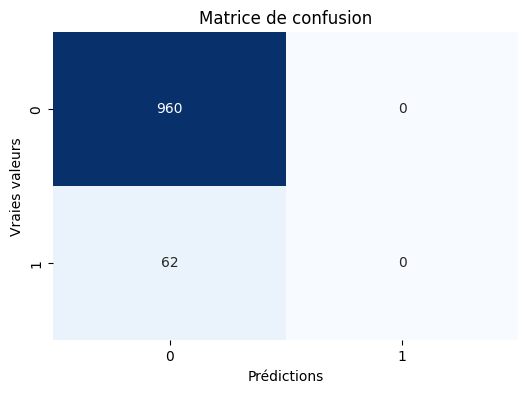

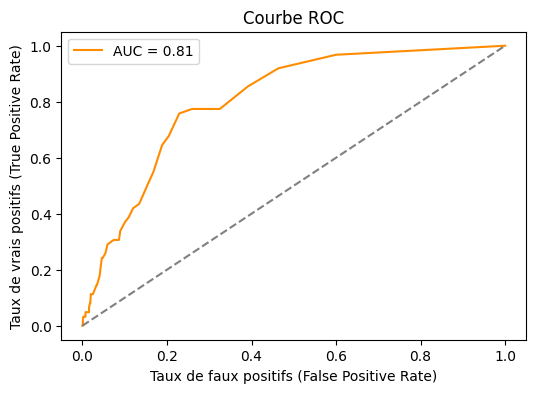

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# visualisation
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matrice de confusion")
plt.ylabel('Vraies valeurs')
plt.xlabel('Prédictions')
plt.show()

from sklearn.metrics import roc_curve, roc_auc_score

y_prob = rf_model.predict_proba(X_test)[:, 1]

# courbe roc et auc
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Ligne référence
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs (False Positive Rate)')
plt.ylabel('Taux de vrais positifs (True Positive Rate)')
plt.legend()
plt.show()

En regardant la matrice de confusion, on peut voir qu'il y a 960 vrais positifs et 62 faux positifs.

#### **Avec suréchantillonnage SMOTE-NC**

Nombre d'échantillons d'entraînement : 7800
Nombre d'échantillons de test : 1022
Exactitude (Accuracy): 0.8924
Rapport de classification :
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       960
           1       0.16      0.18      0.17        62

    accuracy                           0.89      1022
   macro avg       0.55      0.56      0.55      1022
weighted avg       0.90      0.89      0.90      1022



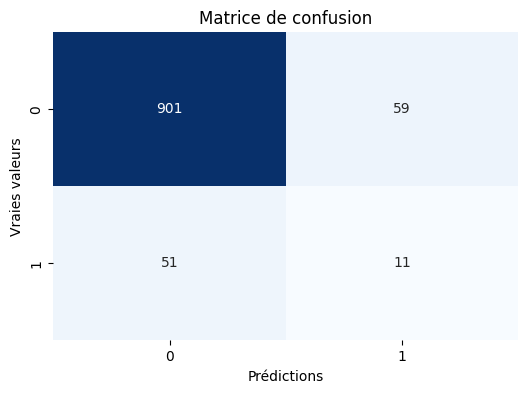

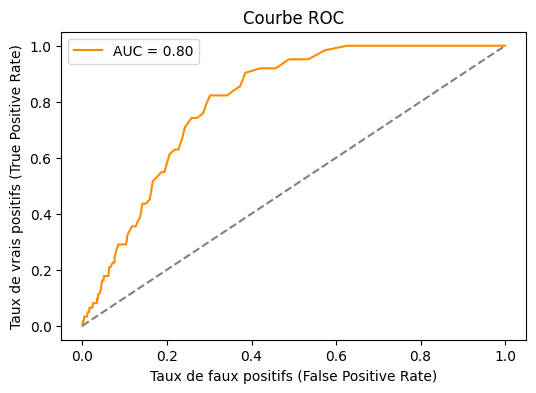

Importance des caractéristiques :
                           Feature  Importance
0                              age    0.383582
4                avg_glucose_level    0.175508
5                              bmi    0.157656
3                     ever_married    0.074869
6                      gender_Male    0.027925
11            Residence_type_Urban    0.027151
1                     hypertension    0.021842
8                work_type_Private    0.021466
13     smoking_status_never smoked    0.021207
12  smoking_status_formerly smoked    0.019311
10              work_type_children    0.019210
14           smoking_status_smokes    0.017784
9          work_type_Self-employed    0.017572
2                    heart_disease    0.014902
7           work_type_Never_worked    0.000014


In [40]:
rf_model_smotenc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_smotenc.fit(X_train_resampled, y_train_resampled)

# prédiction
y_pred = rf_model_smotenc.predict(X_test)
y_prob = rf_model_smotenc.predict_proba(X_test)[:, 1]

# évaluation
print(f"Nombre d'échantillons d'entraînement : {X_train_resampled.shape[0]}")
print(f"Nombre d'échantillons de test : {X_test.shape[0]}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitude (Accuracy): {accuracy:.4f}")

print("Rapport de classification :")
print(classification_report(y_test, y_pred))

# matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matrice de confusion")
plt.ylabel("Vraies valeurs")
plt.xlabel("Prédictions")
plt.show()

# courbe roc
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Ligne référence
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs (False Positive Rate)")
plt.ylabel("Taux de vrais positifs (True Positive Rate)")
plt.legend()
plt.show()

# importance des caractéristiques
importances = rf_model.feature_importances_
features = X.columns

feature_importances = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

print("Importance des caractéristiques :")
print(feature_importances)

## Gradient boosting

On entraîne maintenant un modèle de gradient boosting, sans suréchantillonnage puis avec suréchantillonnage SMOTE-NC.

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

#### **Sans suréchantillonnage**

Nombre d'échantillons d'entraînement : 4087
Nombre d'échantillons de test : 1022
Exactitude (Accuracy): 0.9393
Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


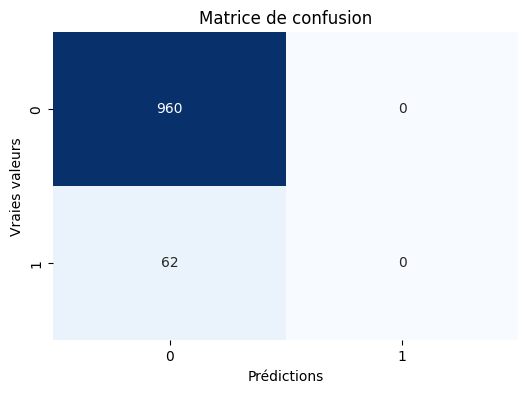

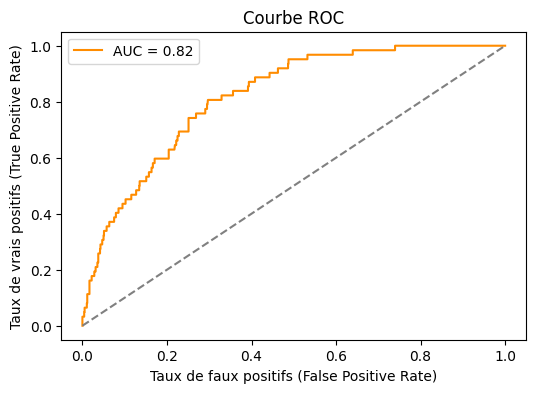

Importance des caractéristiques :
                           Feature  Importance
0                              age    0.401490
4                avg_glucose_level    0.316432
5                              bmi    0.166774
2                    heart_disease    0.033421
1                     hypertension    0.027797
8                work_type_Private    0.014084
9          work_type_Self-employed    0.010037
3                     ever_married    0.009613
13     smoking_status_never smoked    0.008581
12  smoking_status_formerly smoked    0.005757
14           smoking_status_smokes    0.005082
6                      gender_Male    0.000932
7           work_type_Never_worked    0.000000
10              work_type_children    0.000000
11            Residence_type_Urban    0.000000


In [41]:
gb_model = GradientBoostingClassifier(random_state=42)

# entrainement
gb_model.fit(X_train, y_train)

# prédiction
y_pred = gb_model.predict(X_test)
y_prob = gb_model.predict_proba(X_test)[:, 1]

# évaluation
print(f"Nombre d'échantillons d'entraînement : {X_train.shape[0]}")
print(f"Nombre d'échantillons de test : {X_test.shape[0]}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitude (Accuracy): {accuracy:.4f}")

print("Rapport de classification :")
print(classification_report(y_test, y_pred))

# matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matrice de confusion")
plt.ylabel("Vraies valeurs")
plt.xlabel("Prédictions")
plt.show()

# courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Ligne référence
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs (False Positive Rate)")
plt.ylabel("Taux de vrais positifs (True Positive Rate)")
plt.legend()
plt.show()

# importance des caractéristiques
importances = gb_model.feature_importances_
features = X.columns

feature_importances = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

print("Importance des caractéristiques :")
print(feature_importances)

#### **Avec suréchantillonnage SMOTE-NC**

Nombre d'échantillons d'entraînement : 7800
Nombre d'échantillons de test : 1022
Exactitude (Accuracy): 0.8112
Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       960
           1       0.16      0.52      0.25        62

    accuracy                           0.81      1022
   macro avg       0.56      0.67      0.57      1022
weighted avg       0.92      0.81      0.85      1022



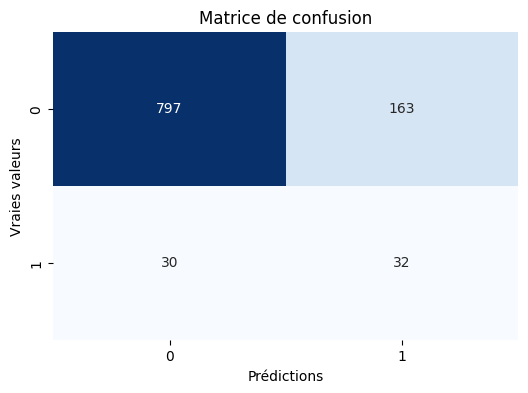

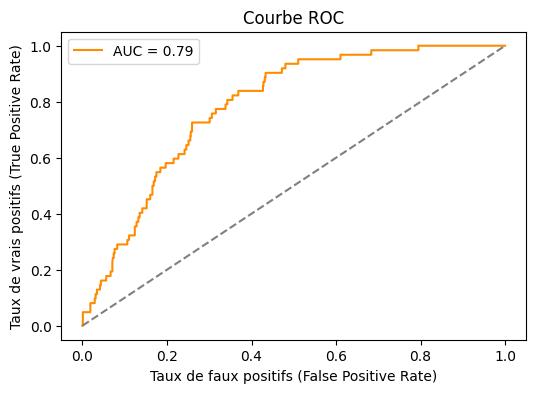

Importance des caractéristiques :
                           Feature  Importance
0                              age    0.401490
4                avg_glucose_level    0.316432
5                              bmi    0.166774
2                    heart_disease    0.033421
1                     hypertension    0.027797
8                work_type_Private    0.014084
9          work_type_Self-employed    0.010037
3                     ever_married    0.009613
13     smoking_status_never smoked    0.008581
12  smoking_status_formerly smoked    0.005757
14           smoking_status_smokes    0.005082
6                      gender_Male    0.000932
7           work_type_Never_worked    0.000000
10              work_type_children    0.000000
11            Residence_type_Urban    0.000000


In [43]:
gb_model_smotenc = GradientBoostingClassifier(random_state=42)

# entraînelent sur données SMOTE-NC
gb_model_smotenc.fit(X_train_resampled, y_train_resampled)

# prediction
y_pred = gb_model_smotenc.predict(X_test)
y_prob = gb_model_smotenc.predict_proba(X_test)[:, 1]

# évaluation du modèle
print(f"Nombre d'échantillons d'entraînement : {X_train_resampled.shape[0]}")
print(f"Nombre d'échantillons de test : {X_test.shape[0]}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitude (Accuracy): {accuracy:.4f}")

print("Rapport de classification :")
print(classification_report(y_test, y_pred))

# matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matrice de confusion")
plt.ylabel("Vraies valeurs")
plt.xlabel("Prédictions")
plt.show()

# courbe roc
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Ligne référence
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs (False Positive Rate)")
plt.ylabel("Taux de vrais positifs (True Positive Rate)")
plt.legend()
plt.show()

# importance des caracteristiques
importances = gb_model.feature_importances_
features = X.columns

feature_importances = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

print("Importance des caractéristiques :")
print(feature_importances)

Globalement, on se rend compte que les modèles qui ont utilisé les données sur lesquelles un suréchantillonnage SMOTE-NC a préalablement été appliqué sont plus efficaces, en particulier pour prédire les futures survenues d'AVC. Il reste toutefois de nombreux faux positifs et faux négatifs.

# Apprentissage non supervisé